# Lab 8 - Integer Programming - BnB for MIP

Information on group members:

1) Student ID, Name and last name <br>
2) Student ID, Name and last name

In [1]:
from pulp import *  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1) Given is the below MIP problem. Note that the first 5 variables are of an integer type with specified upper bounds

In [2]:
def getProblem(relaxed = False):
    
    A = [
        [0,3,2,0,0,0,-3,-1,0,0],
        [1,1,0,2,0,0,0,-1,2,1],
        [0,0,2,-2,3,0,-2,2,1,0],
        [0,0,2,0,0,-1,0,0,0,1],
        [0,2,0,0,0,-2,0,0,0,1],
        [1,4,0,0,0,0,-3,6,2,0],
        [2,2,0,0,2,2,0,0,2,2],
        [0,0,3,0,-1,1,0,-1,0,1],
        [0,0,0,0,5,0,1,1,0,3],
        [2,-7,0,0,0,1,0,8,2,0]]
    b = [10,15,20,20,30,50,40,20,25,25]
    c = [5, 7, 5, 5, 5, 5, 7, 4, 9, 10]
    uB = [5, 8, 4, 5, 4, 5, 5, 3, 3, 3]
    
    problem = LpProblem(name="bnb-problem", sense=LpMaximize)
    
    ### 5 integers and 3 continuous (if relaxed, 8 cont.)
    cat = ['Integer' for i in range(5)] + ['Continuous' for i in range(5)]
    if relaxed: cat = ['Continuous' for i in range(5)] + ['Continuous' for i in range(5)]
        
    x = [LpVariable(name="x"+ str(i+1), lowBound=0, upBound=uB[i], cat = cat[i]) for i in range(10)]
    
    for r in range(10):
        expr = lpSum([x[j] * A[r][j] for j in range(10)])
        problem += LpConstraint(e=expr, sense = -1, name = "baseC"+str(r+1), rhs = b[r])
        
    obj_func = lpSum([x[j] * c[j] for j in range(10)])
    problem += obj_func
    
    return x, problem

x, P = getProblem()
print(P)

bnb-problem:
MAXIMIZE
5*x1 + 10*x10 + 7*x2 + 5*x3 + 5*x4 + 5*x5 + 5*x6 + 7*x7 + 4*x8 + 9*x9 + 0
SUBJECT TO
baseC1: 3 x2 + 2 x3 - 3 x7 - x8 <= 10

baseC2: x1 + x10 + x2 + 2 x4 - x8 + 2 x9 <= 15

baseC3: 2 x3 - 2 x4 + 3 x5 - 2 x7 + 2 x8 + x9 <= 20

baseC4: x10 + 2 x3 - x6 <= 20

baseC5: x10 + 2 x2 - 2 x6 <= 30

baseC6: x1 + 4 x2 - 3 x7 + 6 x8 + 2 x9 <= 50

baseC7: 2 x1 + 2 x10 + 2 x2 + 2 x5 + 2 x6 + 2 x9 <= 40

baseC8: x10 + 3 x3 - x5 + x6 - x8 <= 20

baseC9: 3 x10 + 5 x5 + x7 + x8 <= 25

baseC10: 2 x1 - 7 x2 + x6 + 8 x8 + 2 x9 <= 25

VARIABLES
0 <= x1 <= 5 Integer
x10 <= 3 Continuous
0 <= x2 <= 8 Integer
0 <= x3 <= 4 Integer
0 <= x4 <= 5 Integer
0 <= x5 <= 4 Integer
x6 <= 5 Continuous
x7 <= 5 Continuous
x8 <= 3 Continuous
x9 <= 3 Continuous



2) The below function returns None if the problem has no feasible solutions. Otherwise, it returns a tuple: objective function values and a vector of decision variables. 

In [3]:
def getSolution(x, problem):
    status = problem.solve(PULP_CBC_CMD(msg=False))
    if problem.status != 1: return None
    return problem.objective.value(), [_.value() for _ in x]

3) PuLP can solve MIP problems. Hence, the "relaxed" flag can be set to False. Solve the problem and analyze the obtained outcome.  

In [4]:
x, problem = getProblem(relaxed = False)
print(getSolution(x, problem))
optimum = getSolution(x, problem)[0]

(207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])


4) Now, compare this solution with the one obtained for the relaxed LP problem: 

In [5]:
x, problem = getProblem(relaxed = True)
print(getSolution(x, problem))

(211.33333355000002, [0.73333333, 6.6666667, 4.0, 0.8, 1.6, 5.0, 5.0, 3.0, 3.0, 3.0])


5) Your task is to implement the Branch and Bound Algorithm for solving MIP problems. You can use the PuLP library for solving the relaxed LP subproblems. <br>
<ul> 
    <li> Firstly, as a node selection policy, implement the default DFS-like strategy as shown in the lecture (generate both children in one iteration; prioritize the left children, i.e., associated with the "<=" constraint). As for the variable selection policy, take the one with the lowest index  (default, arbitrary selection). 
<li> Identify how many LP relaxed problems have to be solved to find the optimum. Note that such a number was reported to be 35 for the default policies. However, it may vary slightly for different solvers due to possible multiple sub-optima.
<li> Propose at least 3 new node and variable selection policies with the aim of minimizing the number of solver runs required to reach the optimum.  Try getting below 20. 
    </ul>

### Functions

In [6]:
# as far we cannot copy LPproblem, we performed saving/restoring state manually

def saveVars(x):
    var = []
    for v in x:
        temp = []
        temp.append(v.value())
        temp.append(v.lowBound)
        temp.append(v.upBound)
        var.append(temp)
    return var


def restoreVars(x, var):
    for i, v in enumerate(x):
        v.lowBound = var[i][1]
        v.upBound = var[i][2]
        

node_names = ['BFS', 'DFS', 'Largest Objective', 'Random']
var_names = ['Order', 'First non-integer', 'Order by constraint', 'Random non-integer']
node_score = {}
var_score = {}

### BFS and first non-integer variable

In [7]:
x, problem = getProblem(relaxed = True)
getSolution(x, problem)

nodes = [saveVars(x)]

idx = 0
count = 0

while len(nodes):
    node = nodes.pop(0)
    restoreVars(x, node)
    
    sol = getSolution(x, problem)
    if sol[0] == optimum:
        break
    
    for i, var in enumerate(node):
        split = var[0]
        if not split.is_integer():
            split_left, split_right = np.floor(split), np.ceil(split)
            count += 2
            
            if split_left > x[i].lowBound:
                x[i].upBound = split_left
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            if split_right < x[i].upBound:
                x[i].lowBound = split_right
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            break
    idx += 1  

node_score[0] = count
print(f'\nFound optimum: {sol}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 14


### DFS and first non-integer variable

In [8]:
x, problem = getProblem(relaxed = True)
getSolution(x, problem)

nodes = [saveVars(x)]

idx = 0
count = 0

while len(nodes):
    node = nodes.pop(-1)
    restoreVars(x, node)
    
    sol = getSolution(x, problem)
    if sol[0] == optimum:
        break
    
    for i, var in enumerate(node):
        split = var[0]
        if not split.is_integer():
            split_left, split_right = np.floor(split), np.ceil(split)
            count += 2
            
            if split_right < x[i].upBound:
                x[i].lowBound = split_right
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            if split_left > x[i].lowBound:
                x[i].upBound = split_left
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            break
    idx += 1  

node_score[1] = count
print(f'\nFound optimum: {sol}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 8


### Node with the largest objective and first non-integer variable

In [9]:
x, problem = getProblem(relaxed = True)
sol = getSolution(x, problem)

nodes = [[sol[0], saveVars(x)]]

idx = 0
count = 0

while len(nodes):
    nodes = sorted(nodes, key=lambda x: x[0], reverse=True)
    node = nodes.pop(0)[1]
    restoreVars(x, node)
    
    sol = getSolution(x, problem)
    if sol[0] == optimum:
        break
    
    for i, var in enumerate(node):
        split = var[0]
        if not split.is_integer():
            split_left, split_right = np.floor(split), np.ceil(split)
            count += 2
            
            if split_left > x[i].lowBound:
                x[i].upBound = split_left
                x[i].cat = 'Integer'
                sol = getSolution(x, problem)
                nodes.append([sol[0], saveVars(x)])
                restoreVars(x, node)
                getSolution(x, problem)
            
            if split_right < x[i].upBound:
                x[i].lowBound = split_right
                x[i].cat = 'Integer'
                sol = getSolution(x, problem)
                nodes.append([sol[0], saveVars(x)])
                restoreVars(x, node)
                getSolution(x, problem)

            break
    idx += 1  


node_score[2] = count
print(f'\nFound optimum: {sol}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 10


### Random node and first non-integer variable

In [10]:
x, problem = getProblem(relaxed = True)
getSolution(x, problem)

nodes = [saveVars(x)]

idx = 0
count = 0

while len(nodes):
    node = nodes.pop(np.random.randint(0, len(nodes)))
    restoreVars(x, node)
    
    sol = getSolution(x, problem)
    if sol[0] == optimum:
        break
    
    for i, var in enumerate(node):
        split = var[0]
        if not split.is_integer():
            split_left, split_right = np.floor(split), np.ceil(split)
            count += 2
            
            if split_left > x[i].lowBound:
                x[i].upBound = split_left
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            if split_right < x[i].upBound:
                x[i].lowBound = split_right
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            break
    idx += 1  

node_score[3] = count
print(f'\nFound optimum: {sol}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 24


### Variables by order

In [11]:
x, problem = getProblem(relaxed = True)
getSolution(x, problem)

nodes = [saveVars(x)]
solutions = []

idx = 0
count = 0
var_counter = 0

while len(nodes):
    node = nodes.pop(0)
    restoreVars(x, node)

    sol = getSolution(x, problem)
    if sol and all(map(lambda x: x.is_integer(), sol[1][:5])):
        solutions.append(sol)
    if sol[0] == optimum or var_counter == len(node):
        break

    split = node[var_counter][0]
    if not split.is_integer():
        split_left, split_right = np.floor(split), np.ceil(split)
    else:
        split_left, split_right = split - 1, split

    count += 2
    x[var_counter].upBound = split_left
    x[var_counter].cat = 'Integer'
    getSolution(x, problem)
    nodes.append(saveVars(x))
    restoreVars(x, node)
    getSolution(x, problem)

    x[var_counter].lowBound = split_right
    x[var_counter].cat = 'Integer'
    getSolution(x, problem)
    nodes.append(saveVars(x))
    restoreVars(x, node)
    getSolution(x, problem)
     
    var_counter += 1
    idx += 1  
    
var_score[0] = count
solutions = sorted(solutions, key=lambda x:x[0], reverse=True)
print(f'\nFound optimum: {solutions[0]}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 12


### First non-integer variable

In [12]:
x, problem = getProblem(relaxed = True)
getSolution(x, problem)

nodes = [saveVars(x)]

idx = 0
count = 0

while len(nodes):
    node = nodes.pop(0)
    restoreVars(x, node)
    
    sol = getSolution(x, problem)
    if sol[0] == optimum:
        break
    
    for i, var in enumerate(node):
        split = var[0]
        if not split.is_integer():
            split_left, split_right = np.floor(split), np.ceil(split)
            count += 2
            
            if split_left > x[i].lowBound:
                x[i].upBound = split_left
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            if split_right < x[i].upBound:
                x[i].lowBound = split_right
                x[i].cat = 'Integer'
                getSolution(x, problem)
                nodes.append(saveVars(x))
                restoreVars(x, node)
                getSolution(x, problem)
            
            break
    idx += 1  

var_score[1] = count
print(f'\nFound optimum: {sol}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 14


### Variables ordered by number of invoctions in constraints

In [13]:
x, problem = getProblem(relaxed = True)
getSolution(x, problem)

nodes = [saveVars(x)]
solutions = []

order = [7, 1, 9, 5, 8, 0, 2, 4, 6, 3]
idx = 0
count = 0
var_counter = 0

while len(nodes):
    node = nodes.pop(0)
    restoreVars(x, node)

    sol = getSolution(x, problem)
    if sol and all(map(lambda x: x.is_integer(), sol[1][:5])):
        solutions.append(sol)
    if sol[0] == optimum:
        break

    split = node[order[var_counter]][0]
    if not split.is_integer():
        split_left, split_right = np.floor(split), np.ceil(split)
    else:
        split_left, split_right = split - 1, split

    count += 2
    x[var_counter].upBound = split_left
    x[var_counter].cat = 'Integer'
    getSolution(x, problem)
    nodes.append(saveVars(x))
    restoreVars(x, node)
    getSolution(x, problem)

    x[var_counter].lowBound = split_right
    x[var_counter].cat = 'Integer'
    getSolution(x, problem)
    nodes.append(saveVars(x))
    restoreVars(x, node)
    getSolution(x, problem)
     
    var_counter += 1
    idx += 1  

var_score[2] = count
solutions = sorted(solutions, key=lambda x:x[0], reverse=True)
print(f'\nFound optimum: {solutions[0]}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 12


### Random non-integer variable

In [41]:
x, problem = getProblem(relaxed = True)
getSolution(x, problem)

nodes = [saveVars(x)]
solutions = []

idx = 0
count = 0

while len(nodes):
    node = nodes.pop(0)
    restoreVars(x, node)
    
    sol = getSolution(x, problem)
    if sol and all(map(lambda x: x.is_integer(), sol[1][:5])):
        solutions.append(sol)
    if sol[0] == optimum:
        break
    
    temp = list(filter(lambda x: not x[0].is_integer(), node))
    temp = temp[np.random.randint(0, len(temp))]
    i = node.index(temp)

    split = temp[0]
    split_left, split_right = np.floor(split), np.ceil(split)
    count += 2

    if split_left > x[i].lowBound:
        x[i].upBound = split_left
        x[i].cat = 'Integer'
        getSolution(x, problem)
        nodes.append(saveVars(x))
        restoreVars(x, node)
        getSolution(x, problem)

    if split_right < x[i].upBound:
        x[i].lowBound = split_right
        x[i].cat = 'Integer'
        getSolution(x, problem)
        nodes.append(saveVars(x))
        restoreVars(x, node)
        getSolution(x, problem)
            
    idx += 1  
    
var_score[3] = count
solutions = sorted(solutions, key=lambda x:x[0], reverse=True)
print(f'\nFound optimum: {solutions[0]}')
print(f'Number of subproblems solved: {count}')


Found optimum: (207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])
Number of subproblems solved: 16


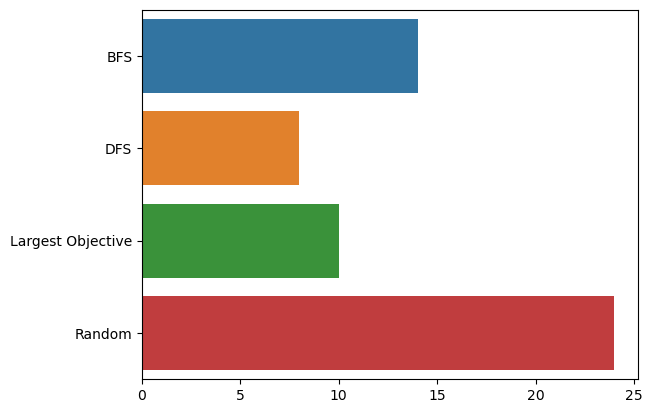

In [21]:
sns.barplot(x=list(node_score.values()), y=node_names);

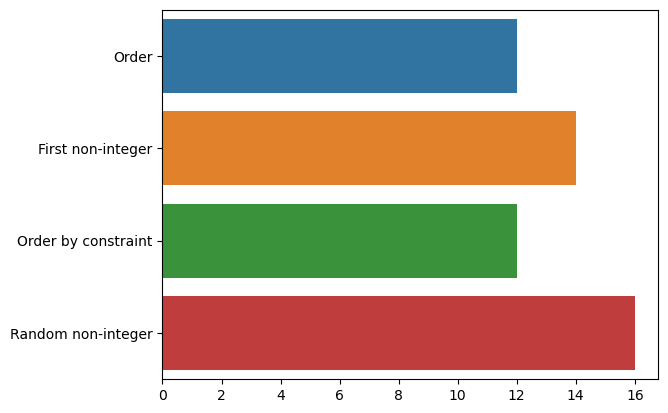

In [42]:
sns.barplot(x=list(var_score.values()), y=var_names);